# Using web scraping and Biopython to extract cancer data from NIH and ASCO to build a consolidated program for search and retrieval of Cancer Research centers and oncologists


---
### Rita Abani 19244
### Department of EECS
### Assignment 1 Submission








In [ ]:
pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 55.1 MB/s 


In [ ]:
from Bio import Entrez

In [ ]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import pickle
from Bio import Entrez
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from collections import defaultdict
from ast import literal_eval

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Goal 1: Let's obtain substantial information on Oncologists.
### This would mainly involve the following :
1. Outsourcing information on the ambit of our sample space, i.e the designated cancer centers or hospitals on the website.The cancer centers have been downloaded from [this link](https://www.cancer.gov/research/nci-role/cancer-centers.). I have uploaded the CSV file in this google colab notebook.
2.Outsourcing or obtaining data about the oncologists working in these centers.In this step, we would scrap data from [this link](https://www.cancer.net/). These are the oncologists that are affiliated to the NCI centers.
3.I have further used Biopython, a python based Bioinformatics package to access the NCBI database through Entrez ([documentation](https://biopython.org/docs/1.75/api/Bio.Entrez.html)). Entrez is an online search system provided by NCBI. It provides access to nearly all known molecular biology databases with an integrated global query supporting Boolean operators and field search. It returns results from all the databases with information like the number of hits from each databases, records with links to the originating database, etc. In our case we would be using Entrez as a tool to obtain the PubMed ID (which can give helpful information about the research track record of an oncologist).
4. We then do some elementary EDA on the information that was compiled through scraping and the use of Entrez to make the onco_df data frame containing information about Oncologists.

In [ ]:
center_df = pd.read_csv('/content/nci_center.csv')

In [ ]:
center_df.head()

,center_name,nci_link
0,Abramson Cancer Center,/research/nci-role/cancer-centers/find/upennab...
1,Albert Einstein Cancer Center,/research/nci-role/cancer-centers/find/alberte...
2,Alvin J. Siteman Cancer Center,/research/nci-role/cancer-centers/find/washing...
3,Arizona Cancer Center,/research/nci-role/cancer-centers/find/arizonacc
4,Case Comprehensive Cancer Center,/research/nci-role/cancer-centers/find/casewes...


In [ ]:
print('Here are {} NCI associated Cancer centers that would encompass our sample space for web scraping: \n{}'.format(center_df.center_name.nunique(), center_df.center_name.values))

Here are 71 NCI associated Cancer centers that would encompass our sample space for web scraping: 
['Abramson Cancer Center ' 'Albert Einstein Cancer Center'
 'Alvin J. Siteman Cancer Center' 'Arizona Cancer Center'
 'Case Comprehensive Cancer Center'
 'Chao Family Comprehensive Cancer Center'
 'City of Hope Comprehensive Cancer Center'
 'Cold Spring Harbor Laboratory Cancer Center'
 'Dan L Duncan Comprehensive Cancer Center'
 'Dana-Farber/Harvard Cancer Center'
 'David H. Koch Institute for Integrative Cancer Research at MIT'
 'Duke Cancer Institute' 'Fox Chase Cancer Center'
 'Fred Hutchinson/University of Washington Cancer Consortium'
 'Fred and Pamela Buffett Cancer Center'
 'Georgetown Lombardi Comprehensive Cancer Center'
 'Harold C. Simmons Comprehensive Cancer Center'
 'Herbert Irving Comprehensive Cancer Center'
 'Holden Comprehensive Cancer Center' 'Hollings Cancer Center'
 'Huntsman Cancer Institute'
 'Indiana University Melvin and Bren Simon Cancer Center'
 'Jonsson Compreh

Information of oncologists affiliated with the NCI-designated cancer centers are scraped now from https://www.cancer.net/find-cancer-doctor as shown below. The information consists of the Name, phone number, speciality and address of the given doctor.

In [ ]:
def extract_oncologist_info(center_name):
    base_url = 'https://www.cancer.net/find-cancer-doctor?Distance=3&Gender=All&Languages=All&longitude=&latitude=&user_latitude=&user_longitude=&user_address=&searchString={}&search_term={}&search_type=name&url='
    center_name2 = center_name.replace(' Comprehensive Cancer Center', "")
    center_name2 = center_name2.replace(' Cancer Center', "")
    center_name2 = center_name2.strip().replace(" ","+")
    search_url=base_url.replace("{}",center_name2)
    
    
    # the html of the search results page is obtained
    html = requests.get(search_url).content
    soup = BeautifulSoup(html,'html.parser')

    # obtain list of oncologists
    doctors = soup.find_all('li',{'class':'fao-result'})
    if len(doctors)==1:
        print('No doctors have been found for {}'.format(center_name))
        return None
    if len(doctors)>1:
        print('{} doctors have been found for {}'.format(len(doctors), center_name))
    
    # extract information for each doctor
    output=defaultdict(list)
    for doc in doctors:
        ## get name of doctor
        for name in doc.find_all('a',{'class':'fao-result-name-link'}):
            output['name'].append(name.get_text()[:name.get_text().find(',')])
            output['degree'].append(name.get_text()[name.get_text().find(',')+1:])
        ## get phone number of doctor
        for phone in doc.find_all('p',{'class':'fao-result-phone'}):
            output['phone'].append(phone.get_text())
        ## get address of doctor
        for add1 in doc.find_all('p',{'class':'fao-result-address-name'}):
            output['center_name2'].append(add1.get_text())
        add2_output=""
        for add2 in doc.find_all('p',{'class':'fao-result-address-street'}):
            add2_output+=add2.get_text()
        output['address'].append(add2_output)
        for add3 in doc.find_all('p',{'class':'fao-result-address-city_state'}):
            output['city_state'].append(add3.get_text())
        ## get speciality of doctor
        for specialities in doc.find_all('div',{'class':'fao-result-specialties'}):
            sepciality_output=[]
            for speciality in specialities.find_all('p'):
                sepciality_output.append(speciality.get_text())
            output['speciality'].append(sepciality_output)
        ## get certificate of doctor
        for certificates in doc.find_all('div',{'class':'fao-result-certs'}):
            certificate_output=[]
            for certificate in certificates.find_all('p'):
                certificate_output.append(certificate.get_text())
            output['certificate'].append(certificate_output)
    data_df=pd.DataFrame.from_dict(output)
    data_df['center_name']=center_name
    return data_df

We then merge the scraped data with the Cancer center's center_df dataframe by performing an intersection operation. (We additionally add those cancer centers that weren't present in the center_df frame but are present in the ASCO data.

In [ ]:
def merge_oncologist_info(center_list):
    data_list=[]
    for center_name in center_list:
        data_df=extract_oncologist_info(center_name)
        if data_df is not None:
            data_list.append(data_df)
    return pd.concat(data_list)

In [ ]:
center_list=list(center_df.center_name.values)+ list(['Johns Hopkins', 'Cleveland Clinic', 'Massachusetts General Hospital'])
onco_df=merge_oncologist_info(center_list)
#We list these hospitals separately owing to their absence in the NCI database but presence on the Cancer website

9 doctors have been found for Abramson Cancer Center 
No doctors have been found for Albert Einstein Cancer Center
No doctors have been found for Alvin J. Siteman Cancer Center
26 doctors have been found for Arizona Cancer Center
9 doctors have been found for Case Comprehensive Cancer Center
No doctors have been found for Chao Family Comprehensive Cancer Center
43 doctors have been found for City of Hope Comprehensive Cancer Center
No doctors have been found for Cold Spring Harbor Laboratory Cancer Center
No doctors have been found for Dan L Duncan Comprehensive Cancer Center
No doctors have been found for Dana-Farber/Harvard Cancer Center
No doctors have been found for David H. Koch Institute for Integrative Cancer Research at MIT
6 doctors have been found for Duke Cancer Institute
24 doctors have been found for Fox Chase Cancer Center
No doctors have been found for Fred Hutchinson/University of Washington Cancer Consortium
No doctors have been found for Fred and Pamela Buffett Cancer

In [ ]:
onco_df=onco_df[-onco_df.name.duplicated()]

In [ ]:
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name
0,John H. Glick,"MD, FASCO",Search for Phone Number,University of Pennsylvania-Abramson Cancer Center,3400 Civic Center Blvd Ste 3-300S,"Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center
1,Arthur M. Feldman,MD,(215) 696-3540,University of Pennsylvania-Abramson Cancer Center,51 N 39th St Ste 103APenn Presbyterian Medcl Ctr,"Philadelphia, PA 19104-2640, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center
3,Kristina Lynne Maletz Novick,MD,Search for Phone Number,Abramson Cancer Center,1425 Portland Ave,"Rochester, NY 14621-3011, US",[],[Radiation Oncology],Abramson Cancer Center
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",3400 Civic Center BlvdPereleman Center for Adv...,"Philadelphia, PA 19104-5127, US","[Clinical Research, Developmental Therapeutics...",[Medical Oncology],Abramson Cancer Center


In [ ]:
print('Number of oncologists found on the website post scraping : {}. Number of cancer centres they are affiliated to:   {} '.format(onco_df.shape[0], onco_df.center_name.nunique()))

Number of oncologists found on the website post scraping : 838. Number of cancer centres they are affiliated to:   44 


<a id='Part2_link'></a>
### 3. Extract publications corresponding to the oncologists from Pubmed using Biopython

<a id='Part2.1_link'></a>
#### We start by first obtaining the Pubmed ID for each article published by each oncologist

In [ ]:
Entrez.email='xieyc10@gmail.com'

In [ ]:
num_list=[]
pub_dict=defaultdict(list)

In [ ]:
for name in onco_df.name:
    if name not in pub_dict:
        search_term='cancer[MESH] AND {}[AUTH]'.format(name)
        search_handle=Entrez.esearch(db='Pubmed',term=search_term,retmax=1000,idtype="acc")
        search_results = Entrez.read(search_handle)
        search_handle.close()
        num_list.append(int(search_results['Count']))
        pub_dict[name]=search_results['IdList']
        time.sleep(0.5)

We then add the above data extracted from pubmed to the onco_df data frame we made earlier.

In [ ]:
onco_df['article_num']=num_list

In [ ]:
onco_df.head()

,name,degree,phone,center_name2,address,city_state,speciality,certificate,center_name,article_num
0,John H. Glick,"MD, FASCO",Search for Phone Number,University of Pennsylvania-Abramson Cancer Center,3400 Civic Center Blvd Ste 3-300S,"Philadelphia, PA 19104-5127, US","[Breast Cancer, Cancer Prevention]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,7
1,Arthur M. Feldman,MD,(215) 696-3540,University of Pennsylvania-Abramson Cancer Center,51 N 39th St Ste 103APenn Presbyterian Medcl Ctr,"Philadelphia, PA 19104-2640, US","[Breast Cancer, Geriatrics Oncology]","[Internal Medicine, Medical Oncology]",Abramson Cancer Center,1
2,David M. Mintzer,MD,Search for Phone Number,Abramson Cancer Center at Pennsylvania Hospital,230 W Washington Sq Fl 2,"Philadelphia, PA 19106-3500, US","[Breast Cancer, Lung Cancer, Palliative Care/E...","[Hematology, Hospice and Palliative Medicine, ...",Abramson Cancer Center,13
3,Kristina Lynne Maletz Novick,MD,Search for Phone Number,Abramson Cancer Center,1425 Portland Ave,"Rochester, NY 14621-3011, US",[],[Radiation Oncology],Abramson Cancer Center,0
4,Charles John Schneider,"MD, FACP",Search for Phone Number,"Hospital of the University of Pennsylvania, Ab...",3400 Civic Center BlvdPereleman Center for Adv...,"Philadelphia, PA 19104-5127, US","[Clinical Research, Developmental Therapeutics...",[Medical Oncology],Abramson Cancer Center,0


For the purpose of maintaining data consistency in terms of avoiding columns with null values, we delete the records of those doctors who don't have any publications on pubmed

In [ ]:
to_del=[]
for i in pub_dict:
    if len(pub_dict[i])==0:
        to_del.append(i)

for i in to_del:
    del pub_dict[i]

In [ ]:
print('Number of doctors with publications: {}'.format(len(pub_dict)))

Number of doctors with publications: 666


<a id='Part5_link'></a>
### 4. Using the information obtained from scraping and biopython used, we perform some elementary EDA starting with the number of oncologists in each cancer center.

<a id='Part5.1_link'></a>
#### Research question : Is there a correlation between the number of oncologists in a cancer facility and the rankings or quality of the cancer institutes (as observed from the trends in research and rankings)

Here, we find the number of oncologists in each cancer center and then study which centres have the largest number of Oncologists. (Intuitively, more number of oncologists would imlpy better funding, more research based collaboration).

In [ ]:
onco_counts_df = onco_df.center_name.value_counts().reset_index().rename(columns={'center_name':'counts','index':'center_name'}).sort_values(by=['counts'],ascending=False)
onco_counts_df.head()

,center_name,counts
0,The University of Texas MD Anderson Cancer Center,133
1,Memorial Sloan-Kettering Cancer Center,109
2,Mayo Clinic Cancer Center,68
3,City of Hope Comprehensive Cancer Center,43
4,Massachusetts General Hospital,36


In [ ]:
onco_counts_df.head()

,center_name,counts
0,The University of Texas MD Anderson Cancer Center,133
1,Memorial Sloan-Kettering Cancer Center,109
2,Mayo Clinic Cancer Center,68
3,City of Hope Comprehensive Cancer Center,43
4,Massachusetts General Hospital,36


In [ ]:
onco_counts_df.info

<bound method DataFrame.info of                                           center_name  counts
0   The University of Texas MD Anderson Cancer Center     133
1              Memorial Sloan-Kettering Cancer Center     109
2                           Mayo Clinic Cancer Center      68
3            City of Hope Comprehensive Cancer Center      43
4                      Massachusetts General Hospital      36
5                                  Yale Cancer Center      35
6   The University of Chicago Comprehensive Cancer...      30
7                                    Cleveland Clinic      27
8                                       Johns Hopkins      26
9                               Arizona Cancer Center      26
11               University of Virginia Cancer Center      24
10                            Fox Chase Cancer Center      24
12  The Ohio State University Comprehensive Cancer...      20
13                              Moffitt Cancer Center      20
14           Roswell Park Comprehensiv

Text(0.5, 1.0, 'Number of oncologists in each cancer center')

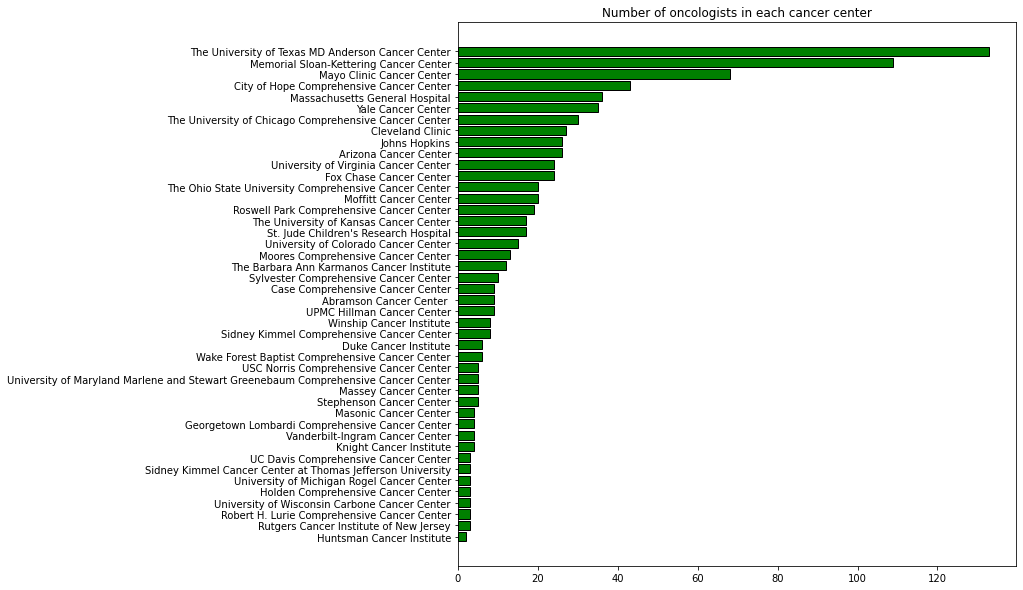

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.barh(np.arange(44),onco_counts_df.counts.values,edgecolor='black',color='green')

ax.set_yticks(np.arange(44))
ax.set_yticklabels(onco_counts_df.center_name.values)
ax.invert_yaxis()
ax.set_title('Number of oncologists in each cancer center')

### We then rank the NIC centres based on the number of oncologists

In [ ]:
print('Cancer centers with the most oncologists are:')
for i in range(5):
    print('Rank {}: {} has {} oncologists'.format(i+1, onco_counts_df.loc[i,'center_name'], onco_counts_df.loc[i,'counts']))

Cancer centers with the most oncologists are:
Rank 1: The University of Texas MD Anderson Cancer Center has 133 oncologists
Rank 2: Memorial Sloan-Kettering Cancer Center has 109 oncologists
Rank 3: Mayo Clinic Cancer Center has 68 oncologists
Rank 4: City of Hope Comprehensive Cancer Center has 43 oncologists
Rank 5: Massachusetts General Hospital has 36 oncologists


According to the **U.S. News & World Report Hospital Rankings & Ratings**, **The University of Texas MD Anderson Cancer Center** ranks 1st in cancer hospitals, **Memorial Sloan-Kettering Cancer Center** ranks 2nd and **Mayo Clinic Cancer Center** ranks 3rd. The trends can be viewed in the screenshot below and on the [official website](https://health.usnews.com/best-hospitals/rankings/cancer) The number of oncologists affiliated with each cancer center is consitent with the overall ranking of these hospitals.

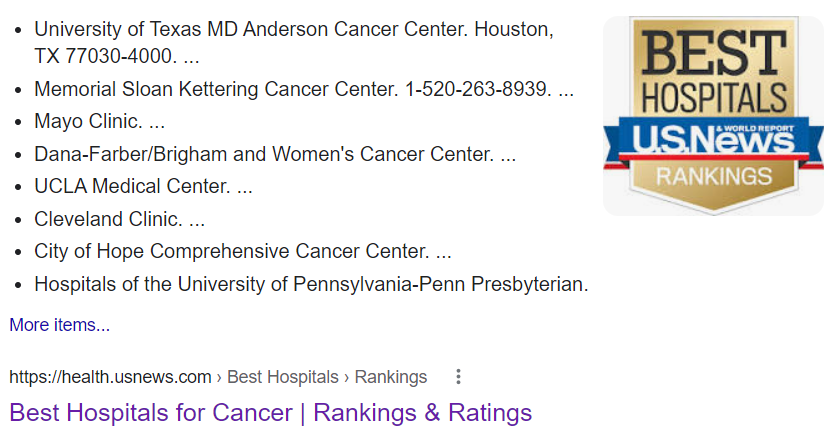

<a id='Part5.2_link'></a>
### Rating the number of publications of Oncologists

In [ ]:
onco_df.columns

Index(['name', 'degree', 'phone', 'center_name2', 'address', 'city_state',
       'speciality', 'certificate', 'center_name', 'article_num'],
      dtype='object')

In [ ]:
onco_df.article_num.max()

2024

In [ ]:
onco_df=onco_df.sort_values(by=['article_num'],ascending=False)
onco_df.reset_index(inplace=True)
print('Oncologists with the most publications are:')
for i in range(5):
    print('Rank {}: {} has {} publications'.format(i+1, onco_df.loc[i,'name'], onco_df.loc[i,'article_num']))

Oncologists with the most publications are:
Rank 1: Jing Li has 2024 publications
Rank 2: Yu Chen has 929 publications
Rank 3: Farhad Ravandi has 627 publications
Rank 4: Gabriel N. Hortobagyi has 609 publications
Rank 5: Leslie L. Robison has 602 publications


Text(0.5, 0, 'log(Number of articles)')

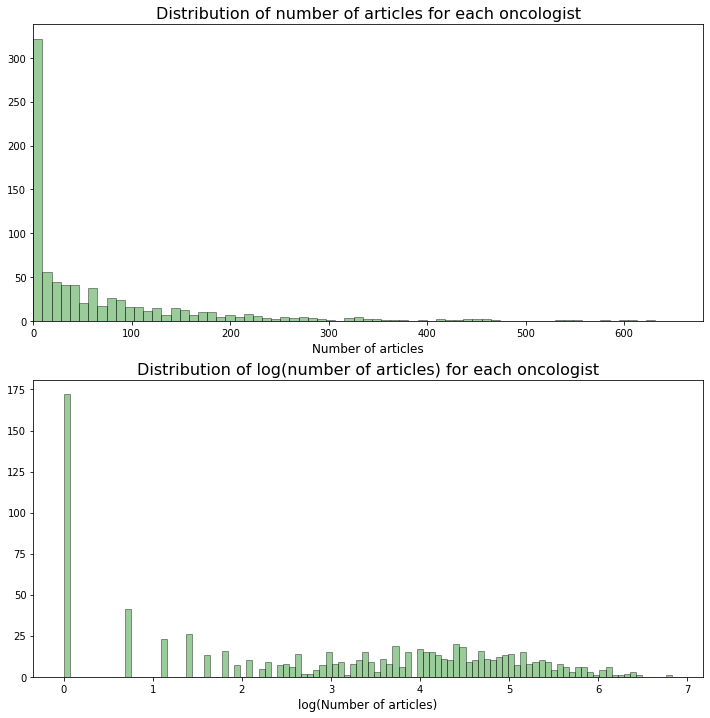

In [ ]:
fig,axes=plt.subplots(2,1,figsize=(12,12))
sns.distplot(onco_df.article_num.iloc[1:].values,hist=True,kde=False,bins=100,ax=axes[0],hist_kws={'edgecolor':'black', 'color': 'green'})
axes[0].set_xlim(0,680)
axes[0].set_title('Distribution of number of articles for each oncologist',fontsize=16)
axes[0].set_xlabel('Number of articles',fontsize=12)

sns.distplot(np.log(onco_df.article_num.iloc[1:].values+1),hist=True,kde=False,bins=100,ax=axes[1],hist_kws={'edgecolor':'black', 'color': 'green'})
axes[1].set_title('Distribution of log(number of articles) for each oncologist',fontsize=16)
axes[1].set_xlabel('log(Number of articles)',fontsize=12)